# Assignment 2
- Train and compare the MLP from Assignment 1 and a simple CNN on the CIFAR-10 dataset (available in PyTorch) with somewhat optimized hyper-parameters
- Visualize several convolutional kernels and activations from the first two convolutional layers
- Train CNNs without regularization, with L2-Regularization, and with L1-Regularization. Compare the results: training and validation loss, accuracy, ...
- Train model with and without data augmentation. Compare the results: training and validation loss, accuracy, ...
- **Extra Point**
   - Implement and use your own custom learning rate warmup and learning rate scheduler criterion to avoid overfitting

In [57]:
import torch
from matplotlib import pyplot as plt
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import os
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import optuna
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()

In [ ]:
%%capture
!pip install optuna
!pip install scikit-learn

In [3]:
# set seeds to replicate results
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [4]:
%%capture
root_cifar = "./cifar10_data/"

train_cifar = torchvision.datasets.CIFAR10(
    root=root_cifar, 
    train=True, 
    transform=torchvision.transforms.ToTensor(), 
    download=True)

test_cifar = torchvision.datasets.CIFAR10(
    root=root_cifar, 
    train=False, 
    transform=torchvision.transforms.ToTensor(), 
    download=True)

In [5]:
print("Train set length:", len(train_cifar.data))
print("Test set length:", len(test_cifar.data))


Train set length: 50000
Test set length: 10000


In [6]:
# define parameters 
BATCH_SIZE = 256
LR = 2e-4
NUM_LABELS = len(torch.unique(torch.tensor(train_cifar.targets)))
LABELS = torch.unique(torch.tensor(train_cifar.targets))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 25

In [7]:
# enable pin memory for faster transfer between CPU and GPU
train_loader = torch.utils.data.DataLoader(
    train_cifar, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True
    )
test_loader = torch.utils.data.DataLoader(
    test_cifar, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True
    )

In [8]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

In [79]:
def plot_results(ax, train_result, train_eval_result, mode=None):

    train_result = np.array(train_result)
    ax[0].plot(train_result, c="blue", label=f"Training {mode}", linewidth=3, alpha=0.5)
    ax[0].plot(smooth(train_result, 10), c="red", label=f"Smoothed Training {mode}", linewidth=3, alpha=0.5)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel(f"CE {mode}")
    ax[0].set_title(f"Training {mode}")

    # since our evaluation loss is a nested list
    train_eval_result = np.array(train_eval_result).flatten()
    ax[1].plot(train_eval_result, c="blue", label=f"Evaluation {mode}", linewidth=3, alpha=0.5)
    ax[1].plot(smooth(train_eval_result, 30), c="red", label=f"Smoothed Evaluation {mode}", linewidth=3, alpha=0.5)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel(f"CE {mode}")
    ax[1].set_title(f"Evaluation {mode}")



## Task 2.1
- Train and compare the MLP from Assignment 1 and a simple CNN on the CIFAR-10 dataset (available in PyTorch) with somewhat optimized hyper-parameters

In [40]:
def Simple_CNN(trial, input_dim, img_shape):
    # set amount of layers to be tested
    n_layers = trial.suggest_int("n_layers", 2, 4)

    h, w = img_shape[0], img_shape[1]

    layers = []
    in_channel = input_dim
    for i in range(n_layers):
        # trial for the hidden dimensions
        hidden_dim = trial.suggest_int(f"n_hidden_dim_l{i}", 8, 32)
        # convolution block: Conv2d, relu, maxpool
        layers.append(nn.Conv2d(in_channels=in_channel, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, ceil_mode=True))
        layers.append(nn.Dropout())
        in_channel = hidden_dim

    # fc size is last hiddem dimension * w/ 2**n_layer * h/ 2**n_layer
    # deviding by layer length because each convolution block has maxpool
    layers.append(nn.Flatten(start_dim=1, end_dim=-1))
    layers.append(nn.Linear(hidden_dim * (h // 2**n_layers) * (w // 2**n_layers), NUM_LABELS))
    return nn.Sequential(*layers)


In [ ]:
def model_train(model, train_loader, test_loader, criterion, optim):
    for batch_idx, (data, target) in enumerate(train_loader):
        # imgs and labels to gpu
        data, labels = data.to(DEVICE), target.to(DEVICE)
        # Removing residual gradients
        optim.zero_grad()
        # Feedforward data through network (Get predictions)
        pred = model(data)
        # Compute training error
        loss = criterion(pred, labels)
        # Backprop and weight update
        loss.backward()
        optim.step()

    ### Evaluation now
    ### Correct = Accumulator of correctly labeled predictions
    correct = torch.zeros(1).to(DEVICE)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, labels = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            ### Summing up correct predictions per batch
            correct += pred.eq(labels.view_as(pred)).sum().item()

    accuracy = correct / len(test_loader.dataset)
    return accuracy

def objective(trial, input_dim, img_shape, num_epochs):
    model = Simple_CNN(trial, input_dim, img_shape).to(DEVICE)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        accuracy = model_train(model, train_loader, test_loader, criterion, optim)
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

inp_dim = train_cifar.data[0].shape[2]
img_size = (train_cifar.data[0].shape[0], train_cifar.data[0].shape[1])
objective_func_args = lambda trial: objective(trial, inp_dim, img_size, NUM_EPOCHS)
study = optuna.create_study(direction="maximize")
study.optimize(objective_func_args, n_trials=20)


[I 2022-11-30 18:50:35,588] A new study created in memory with name: no-name-675daff7-d6b5-4889-9047-2806c464f1d8
[I 2022-11-30 18:58:09,260] Trial 0 finished with value: 0.5388999581336975 and parameters: {'n_layers': 3, 'n_hidden_dim_l0': 237, 'n_hidden_dim_l1': 207, 'n_hidden_dim_l2': 43, 'lr': 0.004879723604988786}. Best is trial 0 with value: 0.5388999581336975.
[I 2022-11-30 19:03:07,293] Trial 1 finished with value: 0.5336999893188477 and parameters: {'n_layers': 2, 'n_hidden_dim_l0': 203, 'n_hidden_dim_l1': 84, 'lr': 2.0789500983857836e-05}. Best is trial 0 with value: 0.5388999581336975.
[I 2022-11-30 19:08:55,829] Trial 2 finished with value: 0.47029998898506165 and parameters: {'n_layers': 4, 'n_hidden_dim_l0': 152, 'n_hidden_dim_l1': 194, 'n_hidden_dim_l2': 77, 'n_hidden_dim_l3': 235, 'lr': 1.706711722555061e-05}. Best is trial 0 with value: 0.5388999581336975.
[I 2022-11-30 19:16:01,025] Trial 3 finished with value: 0.6349999904632568 and parameters: {'n_layers': 2, 'n_hid

Best Values for a Simple CNN:

In [ ]:
print(f"Num trials: {len(study.trials)}")
best_trial = study.best_trial
print(f"Best trial value: {best_trial.value}")
print(f"Obtained params:")
for k, v in best_trial.params.items():
    print(f"{k}: {v}")

Num trials: 20
Best trial value: 0.7396000027656555
Obtained params:
n_layers: 4
n_hidden_dim_l0: 95
n_hidden_dim_l1: 247
n_hidden_dim_l2: 168
n_hidden_dim_l3: 140
lr: 0.00041364507758581936


In [ ]:
## Regarding visualization

## See here: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-tutorial-10-key-features-005-visualization-py

optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [38]:
def define_model(trial, input_dim, num_labels):
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = []
    in_features = input_dim
    for i in range(n_layers):
        out_features = trial.suggest_int(f"n_units_l{i}", 16, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        in_features = out_features
    layers.append(nn.Linear(in_features, num_labels))
    return nn.Sequential(*layers)

def model_train(model, train_loader, test_loader, criterion, optim):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Flattening input data, and getting batch labels
        data, labels = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
        # Removing residual gradients
        optim.zero_grad()
        # Feedforward data through network (Get predictions)
        pred = model(data)
        # Compute training error
        loss = criterion(pred, labels)
        # Backprop and weight update
        loss.backward()
        optim.step()

    ### Evaluation now
    ### Correct = Accumulator of correctly labeled predictions
    correct = torch.zeros(1).to(DEVICE)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, labels = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            ### Summing up correct predictions per batch
            correct += pred.eq(labels.view_as(pred)).sum().item()

    accuracy = correct / len(test_loader.dataset)
    return accuracy

def objective(trial, input_dim, num_labels, num_epochs):
    model = define_model(trial, input_dim, num_labels).to(DEVICE)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        accuracy = model_train(model, train_loader, test_loader, criterion, optim)
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

inp_dim = train_cifar.data[0].flatten().shape[0]
objective_func_args = lambda trial: objective(trial, inp_dim, NUM_LABELS, NUM_EPOCHS)
study = optuna.create_study(direction="maximize")
study.optimize(objective_func_args, n_trials=20)


[I 2022-11-30 16:15:32,986] A new study created in memory with name: no-name-65b397c3-fa49-4af1-bd0d-c336c7589b39
[I 2022-11-30 16:17:48,425] Trial 0 finished with value: 0.43379998207092285 and parameters: {'n_layers': 1, 'n_units_l0': 128, 'lr': 2.996484042294427e-05}. Best is trial 0 with value: 0.43379998207092285.
[I 2022-11-30 16:20:04,215] Trial 1 finished with value: 0.09999999403953552 and parameters: {'n_layers': 1, 'n_units_l0': 51, 'lr': 0.06405568177456669}. Best is trial 0 with value: 0.43379998207092285.
[I 2022-11-30 16:22:23,944] Trial 2 finished with value: 0.41909998655319214 and parameters: {'n_layers': 5, 'n_units_l0': 83, 'n_units_l1': 50, 'n_units_l2': 125, 'n_units_l3': 121, 'n_units_l4': 41, 'lr': 0.0087481467178443}. Best is trial 0 with value: 0.43379998207092285.
[I 2022-11-30 16:24:38,028] Trial 3 finished with value: 0.09999999403953552 and parameters: {'n_layers': 1, 'n_units_l0': 85, 'lr': 0.02513387437192755}. Best is trial 0 with value: 0.4337999820709

In [39]:
print(f"Num trials: {len(study.trials)}")
best_trial = study.best_trial
print(f"Best trial value: {best_trial.value}")
print(f"Obtained params:")
for k, v in best_trial.params.items():
    print(f"{k}: {v}")

Num trials: 20
Best trial value: 0.5116999745368958
Obtained params:
n_layers: 4
n_units_l0: 111
n_units_l1: 63
n_units_l2: 81
n_units_l3: 85
lr: 0.0010159314597812065


In [11]:
class Simple_MLP(nn.Module):

    def __init__(self, input, layers_dims) -> None:
        super().__init__()

        # determine flattened input size
        input_dim = input.flatten().shape[0]

        # mlp layers
        layers = []
        layers.append(nn.Linear(input_dim, layers_dims[0]))
        for i in range(len(layers_dims) - 1):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))
        
        self.lin_layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.lin_layers(x)

In [18]:
# mlp model with custom optuna parameters:
mlp_model = Simple_MLP(input=train_cifar.data[0], layers_dims=[111, 81, 23, 41, NUM_LABELS]).to(DEVICE)
mlp_optim = torch.optim.Adam(mlp_model.parameters(), lr=0.0010159314597812065)
criterion = nn.CrossEntropyLoss()

mlp_train_loss, mlp_train_acc, mlp_train_eval_loss, mlp_train_eval_acc, mlp_all_grad_norms = train(
    mlp_model, train_loader, test_loader, mlp_optim, criterion, NUM_EPOCHS, NUM_LABELS, LABELS, mode="MLP"
    )
_, mlp_confusion_matrix_eval, _ = eval(mlp_model, test_loader, criterion, LABELS, mode="MLP")

Epoch 25 Iter 193: loss 1.40206. : 100%|██████████| 196/196 [00:07<00:00, 24.72it/s]


### Clearly our best CNN accuracy is higher with 73.96% vs our best MLP accuracy with 51.16%, thus our best CNN outperforms our best MLP by a large margin.

## Task 2.2 and Task 2.3
- Train CNNs without regularization, with L2-Regularization, and with L1-Regularization. Compare the results: training and validation loss, accuracy, ...

In [54]:
class Simple_CNN(nn.Module):
    
    def __init__(self, input_dim, dims, img_shape, num_labels) -> None:
        super().__init__()

        h, w = img_shape[0], img_shape[1]

        layers = []
        in_channel = input_dim
        for i in range(len(dims)):
            # trial for the hidden dimensions
            hidden_dim = dims[i]
            # convolution block: Conv2d, relu, maxpool
            layers.append(nn.Conv2d(in_channels=in_channel, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, ceil_mode=True))
            layers.append(nn.Dropout())
            in_channel = hidden_dim

        # fc size is last hiddem dimension * w/ 2**len(dims) * h/ 2**len(dims)
        # deviding by layer length because each convolution block has maxpool
        layers.append(nn.Flatten(start_dim=1, end_dim=-1))
        layers.append(nn.Linear(hidden_dim * (h // 2**len(dims)) * (w // 2**len(dims)), num_labels))
        self.cnn_layers = nn.Sequential(*layers)


    def forward(self, x):
        return self.cnn_layers(x)        

In [50]:
def train(model, train_loader, test_loader, optimizier, criterion, 
    num_epochs, num_labels, all_labels, mode, 
    regularization=None, l1_lambda=1e-4, l2_lambda=1e-4
    ):

    train_loss = []
    train_loss_epoch = []
    train_accs = []
    eval_loss = []
    eval_accs = []

    confusion_matrix = torch.zeros((num_labels, num_labels))

    for epoch in range(num_epochs):
        correct=torch.zeros(1).to(DEVICE)
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (imgs, labels) in pbar:
            model.train()
            
            # use given device
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            # remove gradients
            optimizier.zero_grad()

            #forward pass
            if mode == "MLP":
                imgs = imgs.flatten(start_dim=1)

            output = model(imgs)

            # compute training error
            loss = criterion(output, labels)
            train_loss.append(loss.item())

            # here we do regularization:
            if regularization == "L1":
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm
            elif regularization == "L2":
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss = loss + l2_lambda * l2_norm

            # backprop and weight update
            loss.backward()
            optimizier.step()
            
            # compute accuracy and confusion matrix
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

            # how often in a epoch to update
            pbar_freq = (i % (len(train_loader)//8))
            if(pbar_freq == 0):
                pbar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

        # evaluation after one training epoch
        evaluation_acc, _, evaluation_loss = eval(model, test_loader, criterion, all_labels, mode=mode)

        train_loss_epoch.append(sum(train_loss)/len(train_loss))
        train_loss = []
        train_accs.append((correct / len(train_loader.dataset)).cpu())
        eval_loss.append(evaluation_loss)
        eval_accs.append(evaluation_acc)

    return train_loss_epoch, train_accs, eval_loss, eval_accs

In [14]:
def eval(model, test_loader, criterion, all_labels, mode):
    ### set up confusion matrix
    conf_matx = np.zeros((len(all_labels), len(all_labels)))
    ### Correct = Accumulator of correctly labeled predictions
    correct = torch.zeros(1).to(DEVICE)
    ### list for losses
    loss_list = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, labels = data.to(DEVICE), target.to(DEVICE)
            if mode == "MLP":
                data = data.view(data.size(0), -1)
            output = model(data)
            loss = criterion(output, labels)
            loss_list.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            ### Summing up correct predictions per batch and compute confusion matrix
            correct += pred.eq(labels.view_as(pred)).sum().item()
            conf_matx += confusion_matrix(y_true=labels.cpu().numpy(), y_pred=pred.cpu().numpy(), labels=all_labels)

    accuracy = (correct / len(test_loader.dataset)).cpu()
    return accuracy, conf_matx, loss_list

In [23]:
inp_dim = train_cifar.data[0].shape[2]
img_size = (train_cifar.data[0].shape[0], train_cifar.data[0].shape[1])
cnn_model_no_reg = Simple_CNN(inp_dim , [95, 247, 168, 140], img_size, NUM_LABELS).to(DEVICE)
cnn_optim_no_reg = torch.optim.Adam(cnn_model_no_reg.parameters(), lr=0.00041364507758581936)
criterion = nn.CrossEntropyLoss()

cnn_no_reg_train_loss, cnn_no_reg_train_acc, cnn_no_reg_train_eval_loss, cnn_no_reg_train_eval_acc = train(
    cnn_model_no_reg, train_loader, test_loader, cnn_optim_no_reg, criterion, NUM_EPOCHS, NUM_LABELS, LABELS, mode="CNN"
    )
_, cnn_no_reg_confusion_matrix_eval, _ = eval(cnn_model_no_reg, test_loader, criterion, LABELS, mode="CNN")

Epoch 25 Iter 193: loss 0.72071. : 100%|██████████| 196/196 [00:12<00:00, 15.29it/s]


In [56]:
inp_dim = train_cifar.data[0].shape[2]
img_size = (train_cifar.data[0].shape[0], train_cifar.data[0].shape[1])
cnn_model_l1_reg = Simple_CNN(inp_dim , [95, 247, 168, 140], img_size, NUM_LABELS).to(DEVICE)
cnn_optim_l1_reg = torch.optim.Adam(cnn_model_l1_reg.parameters(), lr=0.00041364507758581936)
criterion = nn.CrossEntropyLoss()

cnn_l1_reg_train_loss, cnn_l1_reg_train_acc, cnn_l1_reg_train_eval_loss, cnn_l1_reg_train_eval_acc = train(
    cnn_model_l1_reg, train_loader, test_loader, cnn_optim_l1_reg, criterion, NUM_EPOCHS, NUM_LABELS, LABELS, mode="CNN", regularization="L1"
    )
_, cnn_l1_reg_confusion_matrix_eval, _ = eval(cnn_model_l1_reg, test_loader, criterion, LABELS, mode="CNN")

Epoch 25 Iter 193: loss 1.44227. : 100%|██████████| 196/196 [00:13<00:00, 14.50it/s]


In [58]:
inp_dim = train_cifar.data[0].shape[2]
img_size = (train_cifar.data[0].shape[0], train_cifar.data[0].shape[1])
cnn_model_l2_reg = Simple_CNN(inp_dim , [95, 247, 168, 140], img_size, NUM_LABELS).to(DEVICE)
cnn_optim_l2_reg = torch.optim.Adam(cnn_model_l2_reg.parameters(), lr=0.00041364507758581936)
criterion = nn.CrossEntropyLoss()

cnn_l2_reg_train_loss, cnn_l2_reg_train_acc, cnn_l2_reg_train_eval_loss, cnn_l2_reg_train_eval_acc = train(
    cnn_model_l2_reg, train_loader, test_loader, cnn_optim_l2_reg, criterion, NUM_EPOCHS, NUM_LABELS, LABELS, mode="CNN", regularization="L2"
    )
_, cnn_l2_reg_confusion_matrix_eval, _ = eval(cnn_model_l2_reg, test_loader, criterion, LABELS, mode="CNN")

Epoch 25 Iter 193: loss 0.98609. : 100%|██████████| 196/196 [00:13<00:00, 14.06it/s]


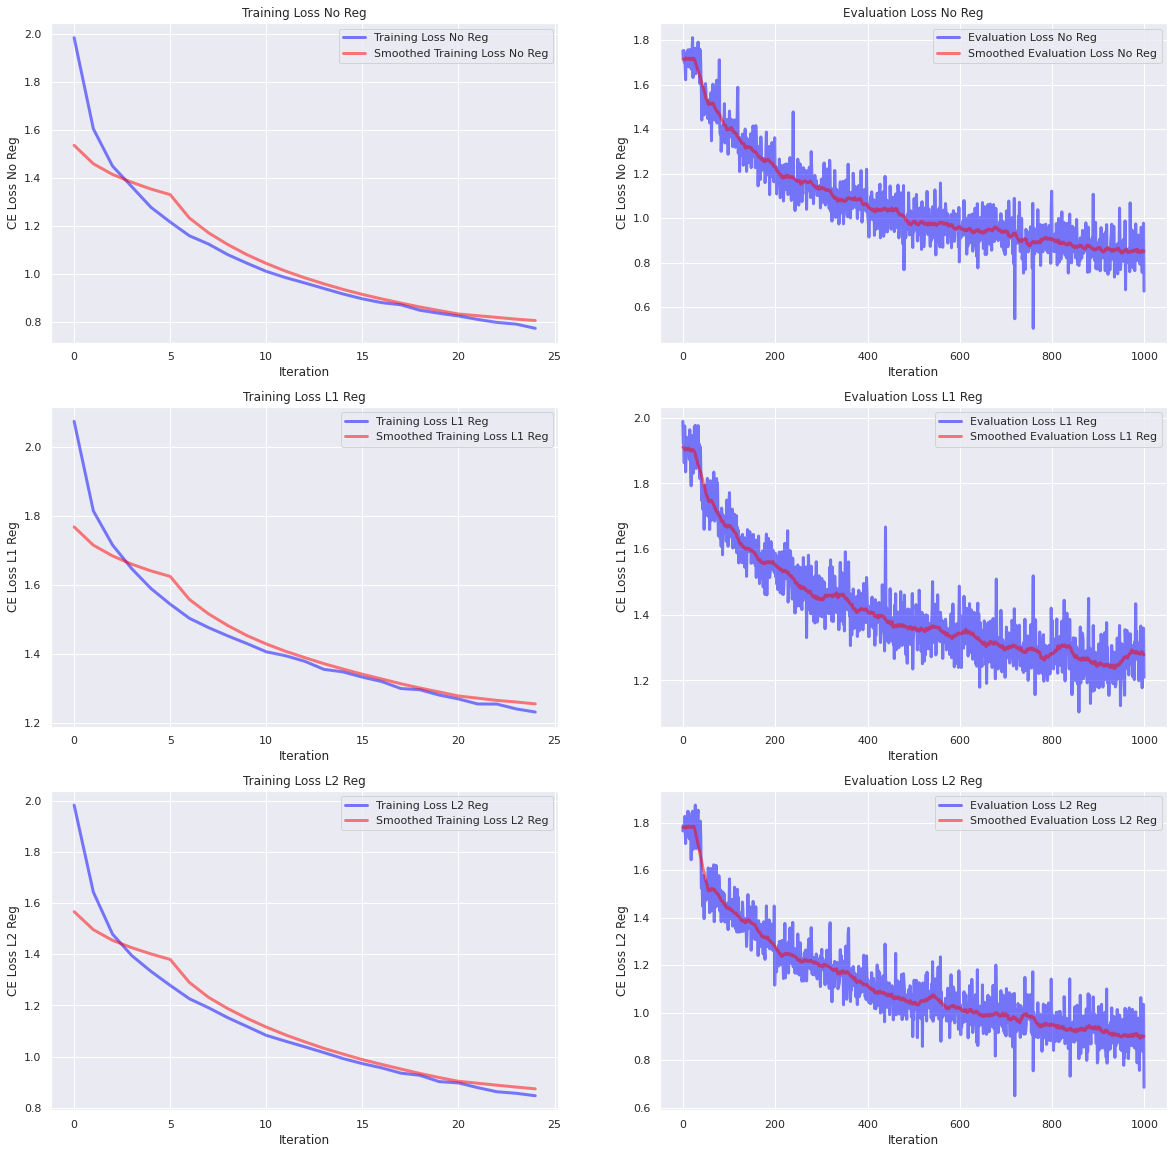

In [122]:
_, ax = plt.subplots(3, 2, figsize=(20,20))
plot_results([ax[0,0], ax[0,1]], cnn_no_reg_train_loss, cnn_no_reg_train_eval_loss, mode="Loss No Reg")
plot_results([ax[1,0], ax[1,1]], cnn_l1_reg_train_loss, cnn_l1_reg_train_eval_loss, mode="Loss L1 Reg")
plot_results([ax[2,0], ax[2,1]], cnn_l2_reg_train_loss, cnn_l2_reg_train_eval_loss, mode="Loss L2 Reg")

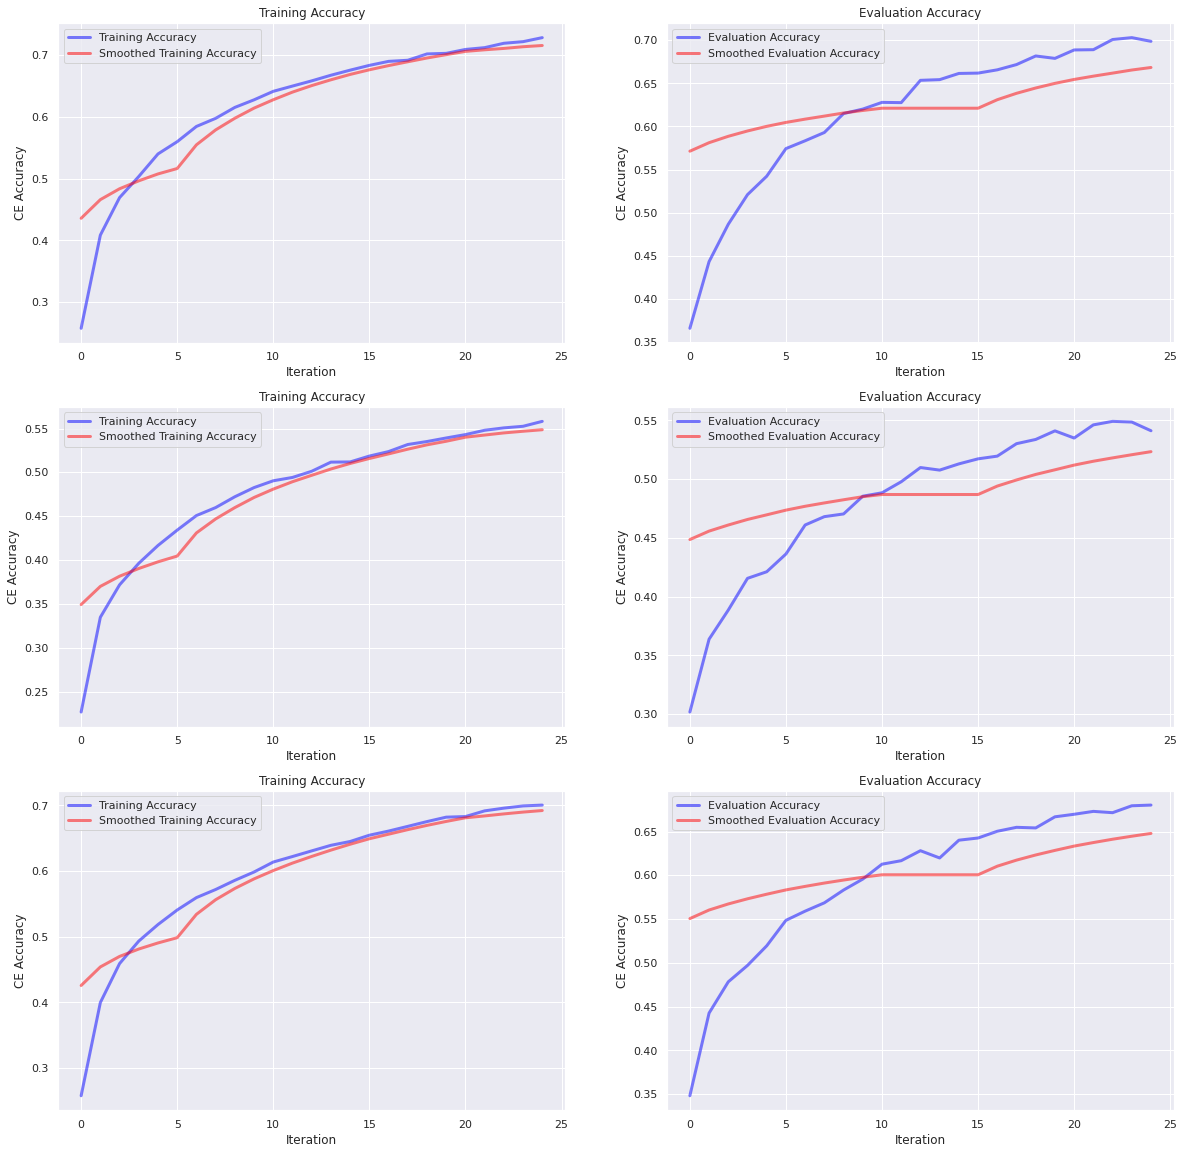

In [81]:
_, ax = plt.subplots(3, 2, figsize=(20,20))
plot_results([ax[0,0], ax[0,1]], cnn_no_reg_train_acc, cnn_no_reg_train_eval_acc, mode="Accuracy No Reg")
plot_results([ax[1,0], ax[1,1]], cnn_l1_reg_train_acc, cnn_l1_reg_train_eval_acc, mode="Accuracy L1 Reg")
plot_results([ax[2,0], ax[2,1]], cnn_l2_reg_train_acc, cnn_l2_reg_train_eval_acc, mode="Accuracy L2 Reg")

### The "No Regularizer" CNN currently gets a better accuracy and less loss than the L1- and L2 regularized CNNs. The reason probably is that the CNN-Weights of the regularized CNNs gets a penalty even though the network is still learning and not overfitting. After certain amounts of epochs trained this will probably change with the L1 and L2 CNNs Accuracy catching up and the loss going further down. 25 Epochs for training CIFAR might not be enough because it has not reached a plateau on the accuracy or converged on the loss yet. The result of the L1 norm is larger than result of the L2 norm, such that the penalization is bigger in the CNN with L1 Norm

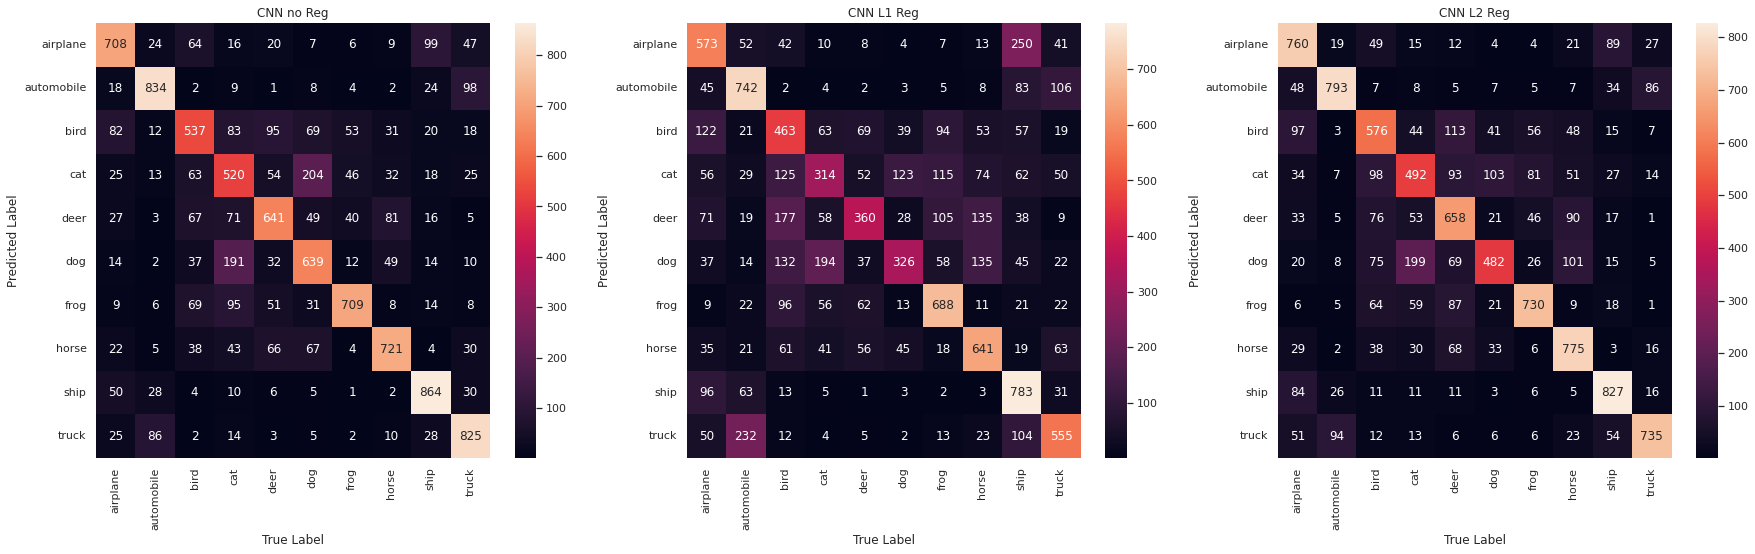

In [82]:
fig, ax = plt.subplots(ncols=3, figsize=(30, 8))
conf_plot1 = sns.heatmap(
    cnn_no_reg_confusion_matrix_eval, annot=True, fmt='g', 
    xticklabels=list(test_cifar.class_to_idx.keys()), yticklabels=list(test_cifar.class_to_idx.keys()),
    ax = ax[0]
    )
conf_plot1.set(title="CNN no Reg",xlabel='True Label', ylabel='Predicted Label')

conf_plot2 = sns.heatmap(
    cnn_l1_reg_confusion_matrix_eval, annot=True, fmt='g', 
    xticklabels=list(test_cifar.class_to_idx.keys()), yticklabels=list(test_cifar.class_to_idx.keys()),
    ax = ax[1]
    )
conf_plot2.set(title="CNN L1 Reg", xlabel='True Label', ylabel='Predicted Label')

conf_plot3 = sns.heatmap(
    cnn_l2_reg_confusion_matrix_eval, annot=True, fmt='g', 
    xticklabels=list(test_cifar.class_to_idx.keys()), yticklabels=list(test_cifar.class_to_idx.keys()),
    ax = ax[2]
    )
conf_plot3.set(title="CNN L2 Reg", xlabel='True Label', ylabel='Predicted Label')

plt.show()

### No clear pattern visible where the CNN confuses the categories except cat and dog. We can see more true positives in the "No Reg" CNN, for the same reasons mentioned above.

In [95]:
print(cnn_model_no_reg)

Simple_CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 95, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(95, 247, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(247, 168, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(168, 140, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (15): Dropout(p=0.5, inplace=False)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=560, out_features=10, bias

torch.Size([3, 42, 62])
torch.Size([95, 107, 62])


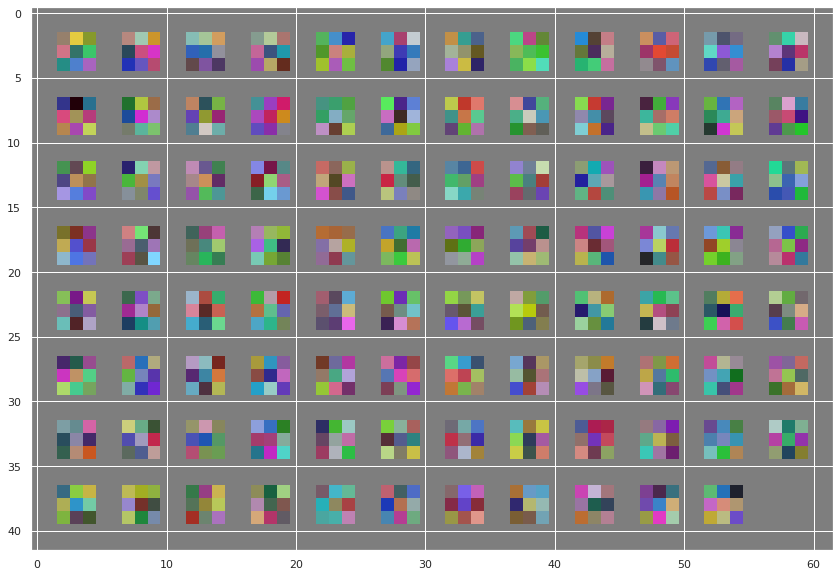

In [115]:
kernels_cnn_layer1 = cnn_model_no_reg.cnn_layers[0].weight.cpu().detach().clone()
kernels_cnn_layer2 = cnn_model_no_reg.cnn_layers[4].weight.cpu().detach().clone()

_, ax = plt.subplots(1, 1, figsize=(20,10))

conv_kern1 = torchvision.utils.make_grid(kernels_cnn_layer1, nrow = 12)
conv_kern2 = torchvision.utils.make_grid(kernels_cnn_layer2, nrow = 12)

# as we can see we cannot plot the second layer because it is not rgb anymore
print(conv_kern1.shape)
print(conv_kern2.shape)

# normalize to (0,1) range so that matplotlib can plot
conv_kern1 = conv_kern1 - conv_kern1.min()
conv_kern1 = conv_kern1 / conv_kern1.max()

ax.imshow(conv_kern1.permute(1, 2, 0))
plt.show()

### We can only display the first cnn layer kernels because the second cnn layer has a kernel dimension of 95 and that cannot be displayed with rgb (3channels). We cannot interpret the kernels, because it is too low level.

## Task 2.4


In [117]:
# data augmentation
# horizontal flip, rotation, random resized crop

h_flip = T.Compose([
    T.RandomHorizontalFlip(p=1),
    T.ToTensor()
])
rotation = T.Compose([
    T.RandomRotation(degrees=(0, 180)),
    T.ToTensor()
])
resize_crop = T.Compose([
    T.RandomResizedCrop(size=(32, 32)),
    T.ToTensor()
])

train_cifar_flipped = torchvision.datasets.CIFAR10(
    root=root_cifar, 
    train=True, 
    transform=h_flip, 
    download=False)

train_cifar_rotated = torchvision.datasets.CIFAR10(
    root=root_cifar, 
    train=True, 
    transform=rotation, 
    download=False)

train_cifar_crop = torchvision.datasets.CIFAR10(
    root=root_cifar, 
    train=True, 
    transform=resize_crop, 
    download=False)

data_augs = [
    train_cifar,
    train_cifar_flipped,
    train_cifar_rotated,
    train_cifar_crop
]

augmented_data = torch.utils.data.ConcatDataset(data_augs)

In [118]:
train_aug_loader = torch.utils.data.DataLoader(
    augmented_data,
    batch_size=BATCH_SIZE, 
    shuffle=True,
    pin_memory=True
)

In [119]:
img_size = (train_cifar.data[0].shape[0], train_cifar.data[0].shape[1])
cnn_model_aug = Simple_CNN(inp_dim , [95, 247, 168, 140], img_size, NUM_LABELS).to(DEVICE)
cnn_optim_aug = torch.optim.Adam(cnn_model_aug.parameters(), lr=0.00041364507758581936)
criterion = nn.CrossEntropyLoss()


cnn_aug_train_loss, cnn_aug_train_acc, cnn_aug_train_eval_loss, cnn_aug_train_eval_acc = train(
    cnn_model_aug, train_aug_loader, test_loader, cnn_optim_aug, criterion, NUM_EPOCHS, NUM_LABELS, LABELS, mode="CNN"
    )
_, cnn_aug_confusion_matrix_eval, _ = eval(cnn_model_aug, test_loader, criterion, LABELS, mode="CNN")

Epoch 25 Iter 777: loss 1.03099. : 100%|██████████| 782/782 [01:10<00:00, 11.10it/s]


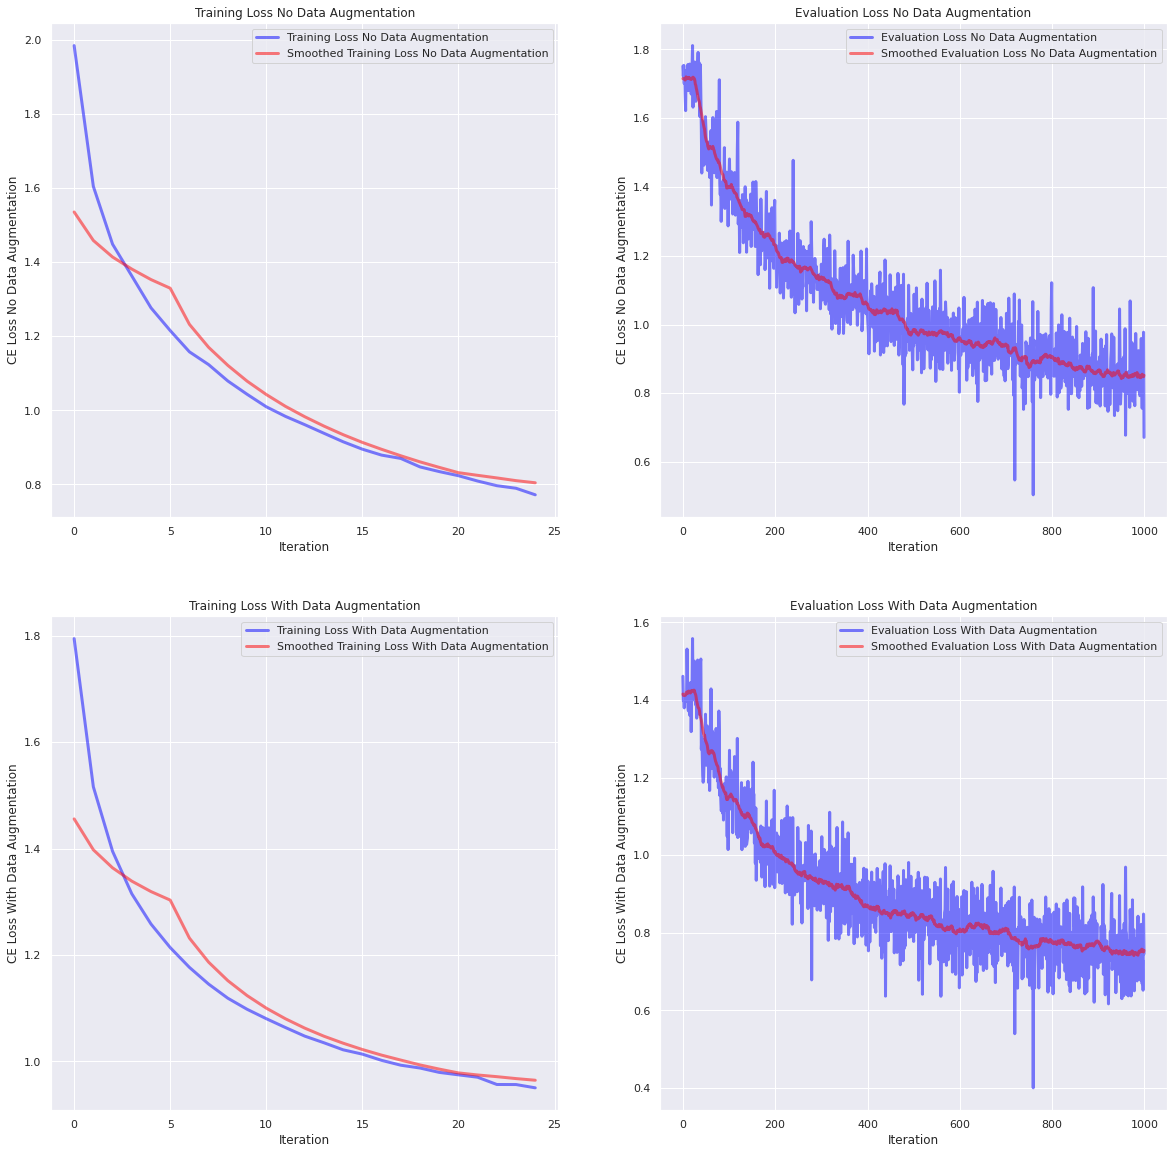

In [120]:
_, ax = plt.subplots(2, 2, figsize=(20,20))
plot_results([ax[0,0], ax[0,1]], cnn_no_reg_train_loss, cnn_no_reg_train_eval_loss, mode="Loss No Data Augmentation")
plot_results([ax[1,0], ax[1,1]], cnn_aug_train_loss, cnn_aug_train_eval_loss, mode="Loss With Data Augmentation")

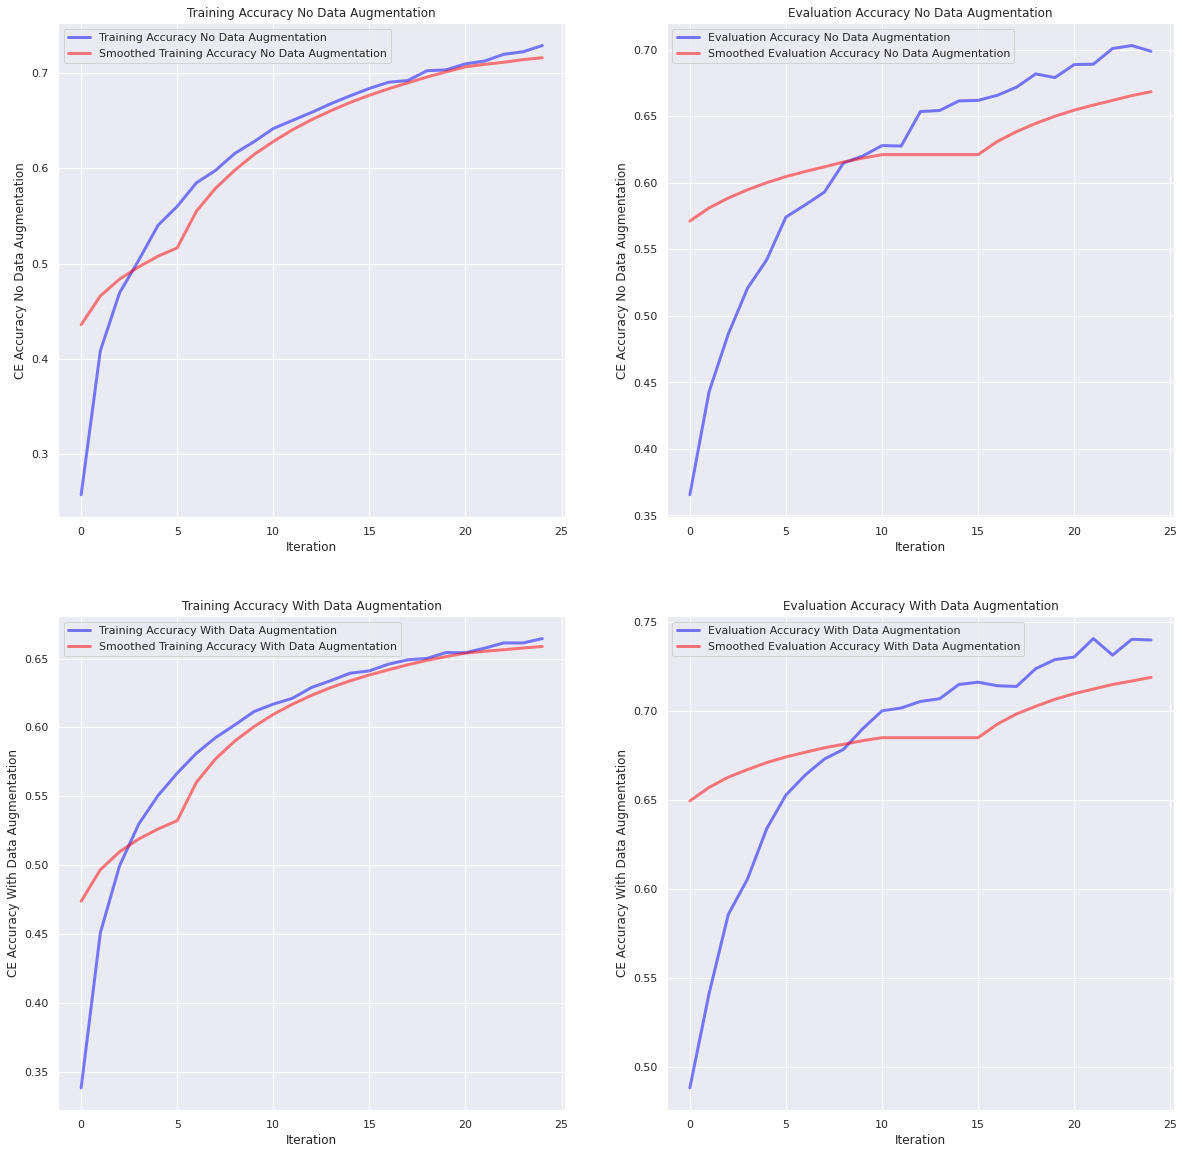

In [121]:
_, ax = plt.subplots(2, 2, figsize=(20,20))
plot_results([ax[0,0], ax[0,1]], cnn_no_reg_train_acc, cnn_no_reg_train_eval_acc, mode="Accuracy No Data Augmentation")
plot_results([ax[1,0], ax[1,1]], cnn_aug_train_acc, cnn_aug_train_eval_acc, mode="Accuracy With Data Augmentation")

### The CNN that trained on the augmented dataset is better performing because it is training for 4x the total images on each epoch and it has adjusted versions of the same images. We need to run it for more epochs >25 and maybe even until complete convergence to compare if it is really better.

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 8))
conf_plot1 = sns.heatmap(
    cnn_no_reg_confusion_matrix_eval, annot=True, fmt='g', 
    xticklabels=list(test_cifar.class_to_idx.keys()), yticklabels=list(test_cifar.class_to_idx.keys()),
    ax = ax[0]
    )
conf_plot1.set(title="CNN no Reg",xlabel='True Label', ylabel='Predicted Label')

conf_plot2 = sns.heatmap(
    cnn_aug_confusion_matrix_eval, annot=True, fmt='g', 
    xticklabels=list(test_cifar.class_to_idx.keys()), yticklabels=list(test_cifar.class_to_idx.keys()),
    ax = ax[1]
    )
conf_plot2.set(title="CNN L1 Reg", xlabel='True Label', ylabel='Predicted Label')


plt.show()

## Extra Task
- **Extra Point**
   - Implement and use your own custom learning rate warmup and learning rate scheduler criterion to avoid overfitting

In [200]:
def get_quadratic_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, alpha=500, last_epoch=-1):

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return alpha * float(current_step) / float(max(1, num_warmup_steps))*float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, alpha * float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))*float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

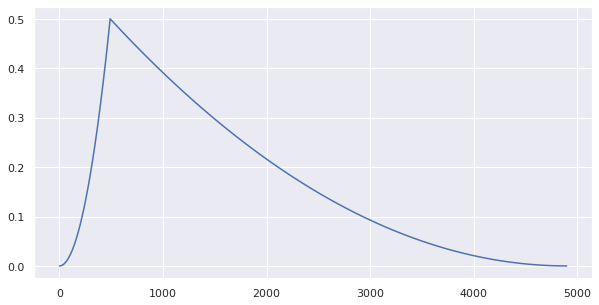

In [201]:
cnn_no_reg_sched_model = Simple_CNN(inp_dim , [95, 247, 168, 140], img_size, NUM_LABELS).to(DEVICE)
# create default adam optim
optim_sched = torch.optim.Adam(cnn_no_reg_sched_model.parameters())
# compute the number of training steps
num_train_steps= int(np.ceil(len(train_cifar.data)/BATCH_SIZE) * NUM_EPOCHS)
# compute the number of warmup steps
num_warm_up_steps = num_train_steps/10
# init scheduler

scheduler = get_quadratic_schedule_with_warmup(optim_sched, num_warm_up_steps, num_train_steps)

lrs = []

for i in range(num_train_steps):
    optim_sched.step()
    lrs.append(optim_sched.param_groups[0]["lr"])
    scheduler.step()

plt.figure(figsize=(10,5))
plt.plot(lrs)
plt.show()

In [202]:
def train_scheduler(model, train_loader, test_loader, optimizer, scheduler, criterion, 
    num_epochs, num_labels, all_labels, mode, 
    regularization=None, l1_lambda=1e-4, l2_lambda=1e-4
    ):

    train_loss = []
    train_loss_epoch = []
    train_accs = []
    eval_loss = []
    eval_accs = []
    lr_val = []

    confusion_matrix = torch.zeros((num_labels, num_labels))

    for epoch in range(num_epochs):
        correct=torch.zeros(1).to(DEVICE)
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (imgs, labels) in pbar:
            model.train()
            
            # use given device
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            # remove gradients
            optimizer.zero_grad()

            #forward pass
            if mode == "MLP":
                imgs = imgs.flatten(start_dim=1)

            output = model(imgs)

            # compute training error
            loss = criterion(output, labels)
            train_loss.append(loss.item())

            # here we do regularization:
            if regularization == "L1":
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm
            elif regularization == "L2":
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss = loss + l2_lambda * l2_norm

            lr_val.append(optimizer.param_groups[0]['lr'])
            # backprop and weight update
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # compute accuracy and confusion matrix
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

            # how often in a epoch to update
            pbar_freq = (i % (len(train_loader)//8))
            if(pbar_freq == 0):
                pbar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

        # evaluation after one training epoch
        evaluation_acc, _, evaluation_loss = eval(model, test_loader, criterion, all_labels, mode=mode)

        train_loss_epoch.append(sum(train_loss)/len(train_loss))
        train_loss = []
        train_accs.append((correct / len(train_loader.dataset)).cpu())
        eval_loss.append(evaluation_loss)
        eval_accs.append(evaluation_acc)

    return train_loss_epoch, train_accs, eval_loss, eval_accs, lr_val

In [203]:
criterion = nn.CrossEntropyLoss()

cnn_sched_train_loss, cnn_sched_train_acc, cnn_sched_train_eval_loss, cnn_sched_train_eval_acc, lr_val = train_scheduler(
    cnn_no_reg_sched_model, train_loader, test_loader, optim_sched, scheduler, criterion, NUM_EPOCHS, NUM_LABELS, LABELS, mode="CNN"
    )
_, cnn_sched_confusion_matrix_eval, _ = eval(cnn_no_reg_sched_model, test_loader, criterion, LABELS, mode="CNN")

Epoch 25 Iter 193: loss 2.31502. : 100%|██████████| 196/196 [00:16<00:00, 12.22it/s]


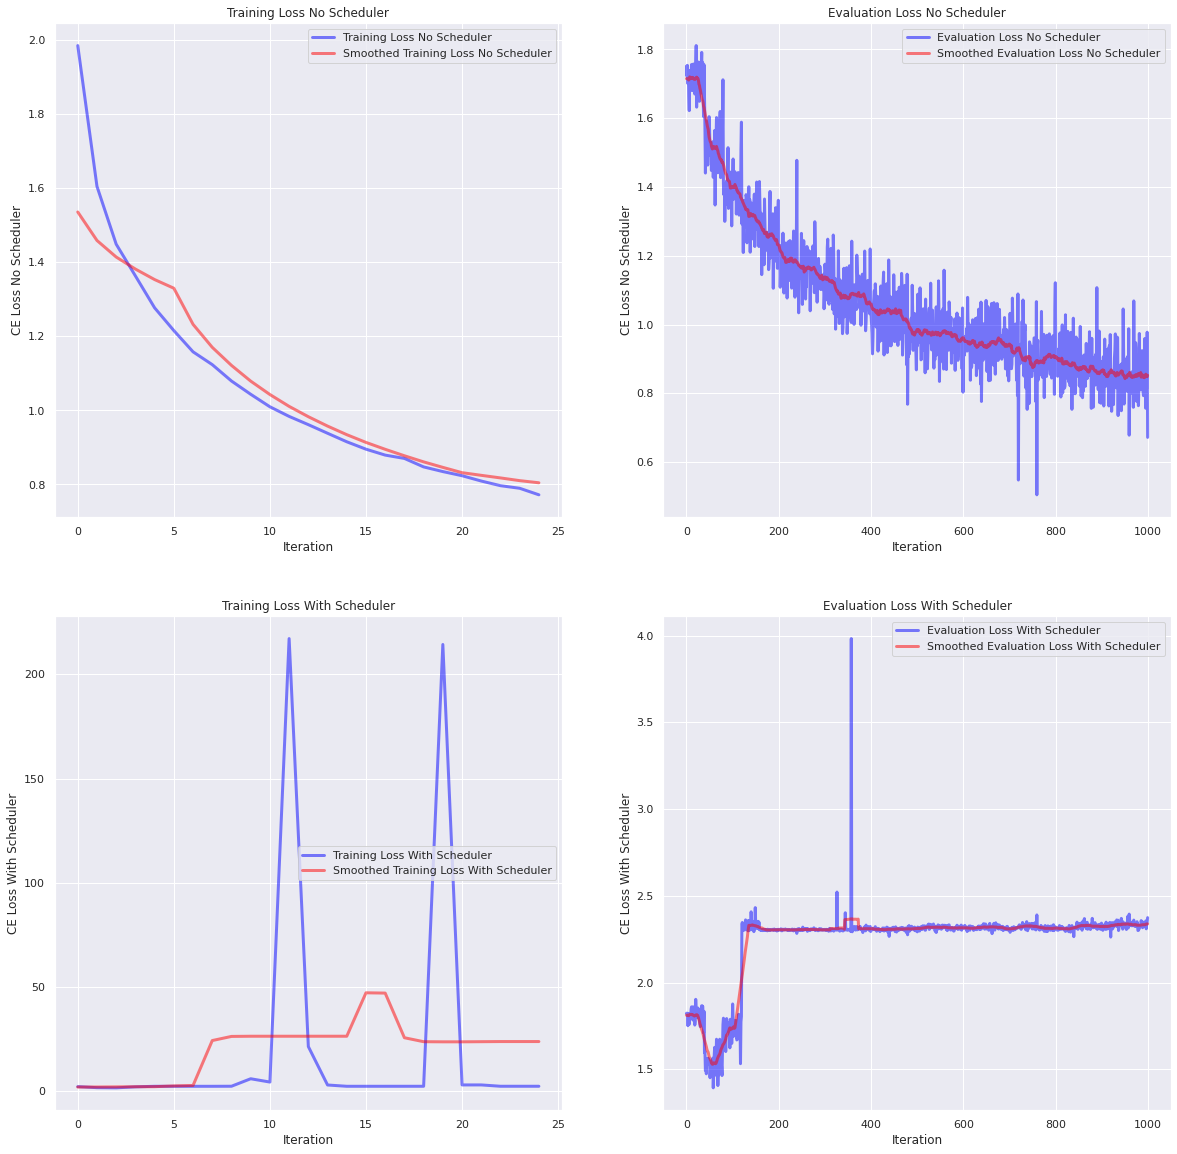

In [204]:
_, ax = plt.subplots(2, 2, figsize=(20,20))
plot_results([ax[0,0], ax[0,1]], cnn_no_reg_train_loss, cnn_no_reg_train_eval_loss, mode="Loss No Scheduler")
plot_results([ax[1,0], ax[1,1]], cnn_sched_train_loss, cnn_sched_train_eval_loss, mode="Loss With Scheduler")

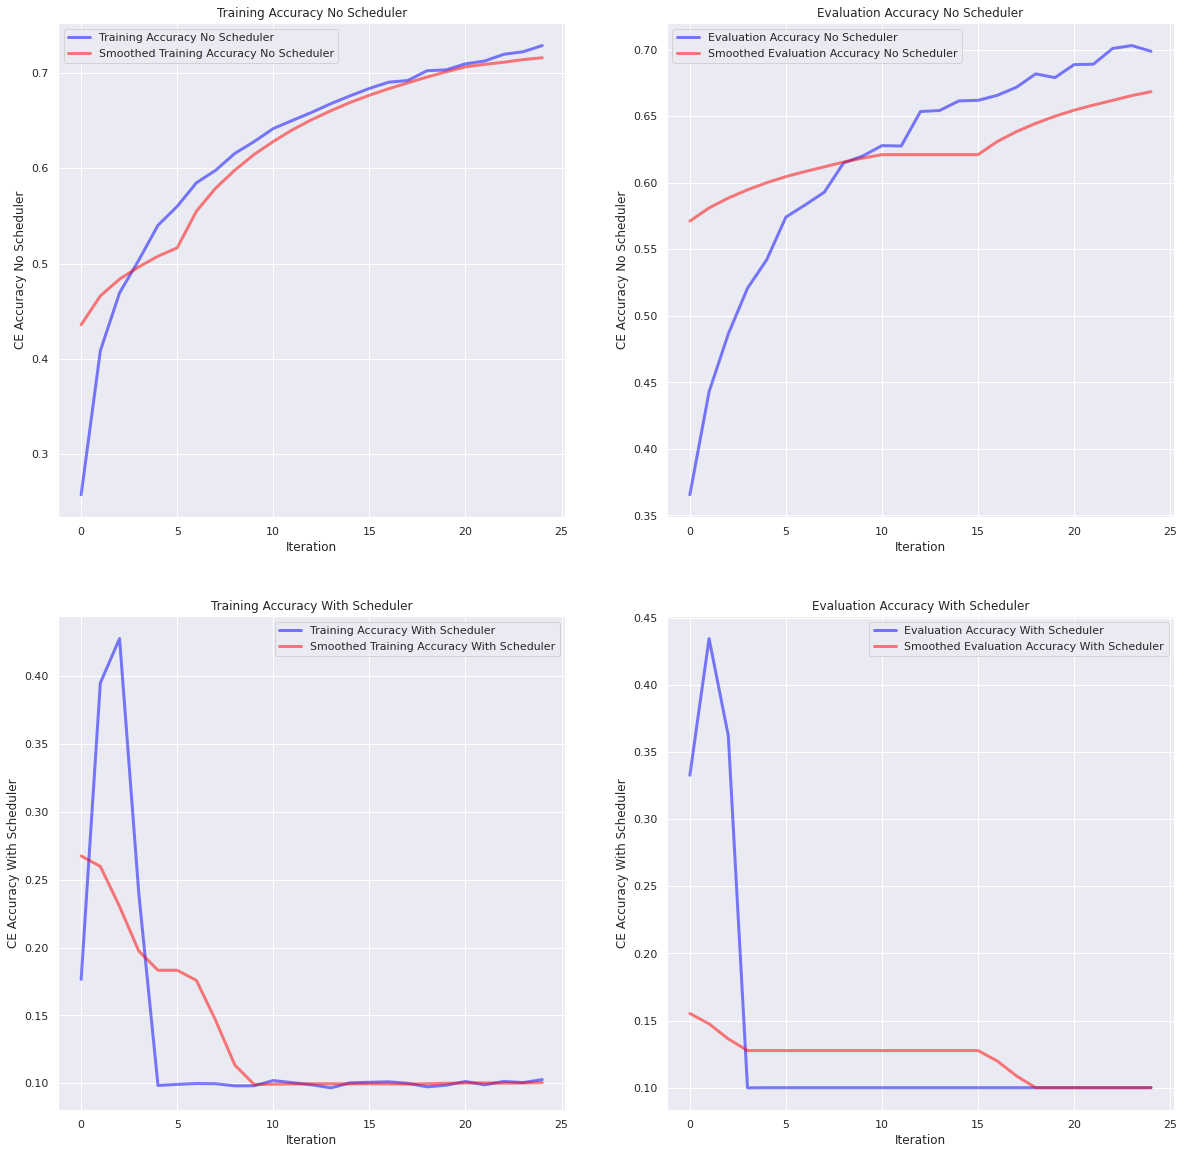

In [207]:
_, ax = plt.subplots(2, 2, figsize=(20,20))
plot_results([ax[0,0], ax[0,1]], cnn_no_reg_train_acc, cnn_no_reg_train_eval_acc, mode="Accuracy No Scheduler")
plot_results([ax[1,0], ax[1,1]], cnn_sched_train_acc, cnn_sched_train_eval_acc, mode="Accuracy With Scheduler")

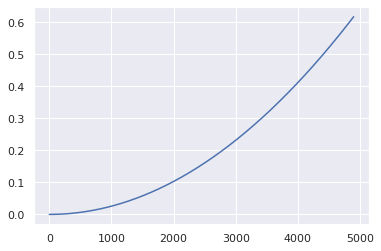

In [206]:
plt.plot(lr_val)

### Optimizer seems to be at different LR than Scheduler is set